# Phase 2 - Data preprocessing
### Authors: Karolina Skrypova(50%), Oleh Fedunchyk(50%)

## Importing libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

## Loading the data

In [91]:
connections_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/connections.csv', sep='\t')
processes_data = pd.read_csv('https://raw.githubusercontent.com/myrres0/IAU-2024/main/dataset-120/processes.csv', sep='\t')

## Datasets for processing

Our constants:

In [92]:
selected_attributes = [
    "mwra",
    "p.android.externalstorage",
    "p.android.settings",
    "p.android.gm",
    "p.system",
    "p.android.packageinstaller",
    "c.android.gm",
    "c.android.youtube",
    "p.android.chrome",
    "c.android.chrome"
]

In [104]:
def divide_df(df):
    mwra = df['mwra']
    df_ = df.drop('mwra', axis=1)
    return train_test_split(df_, mwra, test_size=0.2, random_state=42)

In [105]:
merged_data = pd.merge(processes_data, connections_data).drop_duplicates()
train_data, test_data, mwra_train, mwra_test = divide_df(merged_data[selected_attributes])

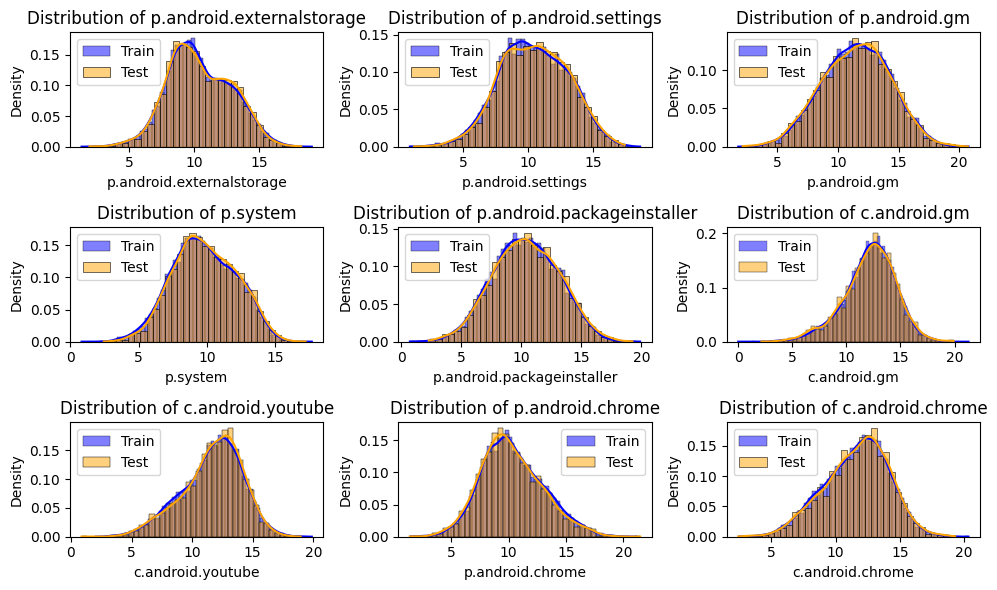

In [113]:
num_columns = 3
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, num_rows * 2))
axes = axes.flatten()

for idx, column in enumerate(train_data.columns):
    sns.histplot(train_data[column], color='blue', label='Train', kde=True, stat="density", ax=axes[idx])
    sns.histplot(test_data[column], color='orange', label='Test', kde=True, stat="density", ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## Data pre-processing pipeline

### Data cleaning

In [139]:
class Cleaner(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.apply(self.resolve_missing_values)
        return X_.apply(self.transform_outliers)

    # we do not have NA values in our dataset, but let this step be in our pipeline
    def resolve_missing_values(self, column):
        return column.fillna(column.median())

    # we have checked mrwa have no outliers so can also be proceeded by this function
    def transform_outliers(self, column):
      Q1 = column.quantile(0.25)
      Q3 = column.quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      outliers = column[(column < lower_bound) | (column > upper_bound)]
      cleaned_column = column.clip(lower=lower_bound, upper=upper_bound)

      return cleaned_column

### Data transforming

In [96]:
class Transformer(TransformerMixin):
    def __init__(self):
        self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

    def fit(self, X, y=None):
        self.power_transformer.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.power_transformer.transform(X), columns=X.columns)

### Data scaling

In [140]:
class Scaler(TransformerMixin):
    def __init__(self):
        self.standard_scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.standard_scaler.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.standard_scaler.transform(X), columns=X.columns)

### Pipeline

In [141]:
pipeline = Pipeline([
    ('cleaner', Cleaner()),
    ('transformer', Transformer()),
    ('scaler', Scaler())
]).fit(train_data, mwra_train)

In [142]:
train_data_transformed = pipeline.transform(train_data)
test_data_transformed = pipeline.transform(test_data)

## 3.1 Simple ID3 classifier based on dependencies in the data

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)

# Assuming 'train_data_transformed', 'test_data_transformed', and 'mwra_test' are defined

# Train the classifier using the transformed data
clf.fit(train_data_transformed, mwra_train)

# Make predictions using the transformed data
y_pred = clf.predict(test_data_transformed)

# Evaluate the classifier
accuracy = accuracy_score(mwra_test, y_pred)
precision = precision_score(mwra_test, y_pred, average='binary')
recall = recall_score(mwra_test, y_pred, average='binary')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Check for overfitting
train_pred = clf.predict(train_data_transformed)  # Use transformed data for training prediction
train_accuracy = accuracy_score(mwra_train, train_pred)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy}")

Accuracy: 0.9109964527571751
Precision: 0.9208121827411168
Recall: 0.937952430196484
Train Accuracy: 0.9191389874234118
Test Accuracy: 0.9109964527571751
